# Leitura do arquvio .csv, contendo os fatores de emissão.

In [184]:
import pandas as pd #Importa a biblioteca pandas as pd
import os           #Importa a biblioteca os

cwd = os.getcwd()   # cwd recebe o endereço do script

path = cwd+'\\tabelas\\FE'      #path recebe o endereço onde está o arquivo do fatores de emissão
print(path)                     #imprime o path para verificação

chapterNumer = 11
subChapter = 7
file = 'chpt_'+str(chapterNumer)+'_'+str(subChapter)+'.csv'  #file recebe path + o nome do arquivo
print(file)                       

fe = pd.read_csv(path+'\\'+file)            #fe recebe o arquivo csv
display(fe)

C:\Guilherme\ControleP\ENS410064\venv\Scripts\tabelas\FE
chpt_11_7.csv


,Source,PM,SO2,NOX
0,BMP,0.0060,0.0,0.00
1,Secador,1.1500,0.0,0.00
2,Resfriador,0.0550,0.0,0.00
3,Granulacao,0.0950,0.0,0.00
4,Queima,0.2450,104.5,0.27
5,Refrigeracao,0.0335,0.0,0.00
6,Esmatacao,0.0950,0.0,0.00


# Função para leitura dos fatores de emissão e estimar a emissão

In [185]:
import matplotlib.pyplot as plt
import numpy as np

def verificacao_emissao (fe, df):
    
    emissao_pm_total = np.zeros(8737)     #Inicializa um vetor de 8737 posições (horas do ano), para calcular as emissões   
    emissao_so2_total = np.zeros(8737)    #Inicializa um vetor de 8737 posições (horas do ano), para calcular as emissões   
    emissao_nox_total = np.zeros(8737)    #Inicializa um vetor de 8737 posições (horas do ano), para calcular as emissões   
    df_emissao_por_fonte = pd.DataFrame(columns = ['Source', 'PM', 'SO2', 'NOX'])

#-------------------------------------Cálculo da emissão de PM durante o ano--------------------------------------------#
    
    for i, row in fe.iterrows():
        # Multiplicar cada valor na coluna producao_diaria de df pelo valor correspondente na linha i da coluna PM de fe
        emissao_pm = df['producao_diaria'] * row['PM'] # esse calcula nos dá um resultado na unidade kg/h 
        # Adicionar emissao_pm ao DataFrame emissao_pm
        df_emissao_por_fonte.loc[i, 'Source'] = row['Source']
        df_emissao_por_fonte.loc[i, 'PM'] = np.mean(emissao_pm)
        emissao_pm_total += emissao_pm
        

#-------------------------------------Cálculo da emissão de SO2 durante o ano--------------------------------------------#
    
    for j, row in fe.iterrows():
        # Multiplicar cada valor na coluna producao_diaria de df pelo valor correspondente na linha i da coluna PM de fe
        emissao_so2 = df['producao_diaria'] * row['SO2']
        # Adicionar emissao_so2 ao DataFrame emissao_so2_total
        df_emissao_por_fonte.loc[j, 'Source'] = row['Source']
        df_emissao_por_fonte.loc[j, 'SO2'] = np.mean(emissao_so2)
        emissao_so2_total += emissao_so2

#-------------------------------------Cálculo da emissão de NOX durante o ano--------------------------------------------#
    
    for k, row in fe.iterrows():
        # Multiplicar cada valor na coluna producao_diaria de df pelo valor correspondente na linha i da coluna PM de fe
        emissao_nox = df['producao_diaria'] * row['NOX']
        # Adicionar emissao_nox ao DataFrame emissao_nox_total
        df_emissao_por_fonte.loc[k, 'Source'] = row['Source']
        df_emissao_por_fonte.loc[k, 'NOX'] = np.mean(emissao_nox)
        emissao_nox_total += emissao_nox

#-------------------------------------Calculo de emissao de PM por processo --------------------------------------------#

    fig,ax = plt.subplots(len(fe.columns)-1,1,sharex = True, figsize = (9,15))
    for ii in range(1,len(fe.columns)): #  Este loop for itera sobre os números de 1 até o número de COLUNAS em fe (len(fe.columns)). O uso de range(1, len(fe.columns)) exclui a primeira coluna
        ax[ii-1].bar(fe['Source'],fe.iloc[:,ii],color = ['#DAF7A6','red','cyan', 'green', 'blue', 'magenta','purple'])
        ax[ii-1].set_xlabel('Processo', fontsize=12) #fontsize=8 é um argumento usado para definir o tamanho da fonte
        ax[ii-1].set_ylabel(fe.columns[ii]+'\n(kg/ton)', fontsize=12)

    return emissao_pm_total, emissao_so2_total, emissao_nox_total, df_emissao_por_fonte #retorna a rotina principal 3 vetores contendo a emissão de cada particula no ano




# Criar sazonalidade e método monte carlo para estimar a produção em 1 ano (2023)

In [186]:
#criando o dataframe contendo todas as horas de 2023
i = pd.date_range(start='2023-01-01', end='2023-12-31', freq ='h') #cria um indice contendo todas as horas e dias do ano de 2023
df = pd.DataFrame(index = i) # cria um dataframe sendo que as linhas são as horas do ano


# Modelando a sazonalidade nos dias do ano usando uma função seno
df['sazonalidade'] = np.sin(2 * np.pi * df.index.dayofyear / 365) + 1  # Adicionando 1 para evitar valores de produção negativos

#aplicando o método de monte carlo utilizando a biblioteca numpy

#considerando a produção de 535945.3782kg no ano de 2023, temos a taxa média por hora de 62.0307 kg/h. 

min_producao_hora = 62.0307*0.1        # como o processo não possui eventos sem atividade, então foi definido como mínimo 10% da capacidade média
max_producao_hora = 62.0307*1.1 # produção máxima definida, foi 50% mais que a capacidade média

#método Monte Carlo:

variabilidade = np.random.uniform(min_producao_hora, max_producao_hora, len(df))

df['variabilidade'] = variabilidade

#Multiplicando a sazonalidade com a variabilidade criada pelo método monte carlo, para assim termos as taxas. 

df['producao_diaria'] = df['sazonalidade']*df['variabilidade']


# Chamando a função *verificacao_emissao()* para calcular as emissões por processo e por particula 

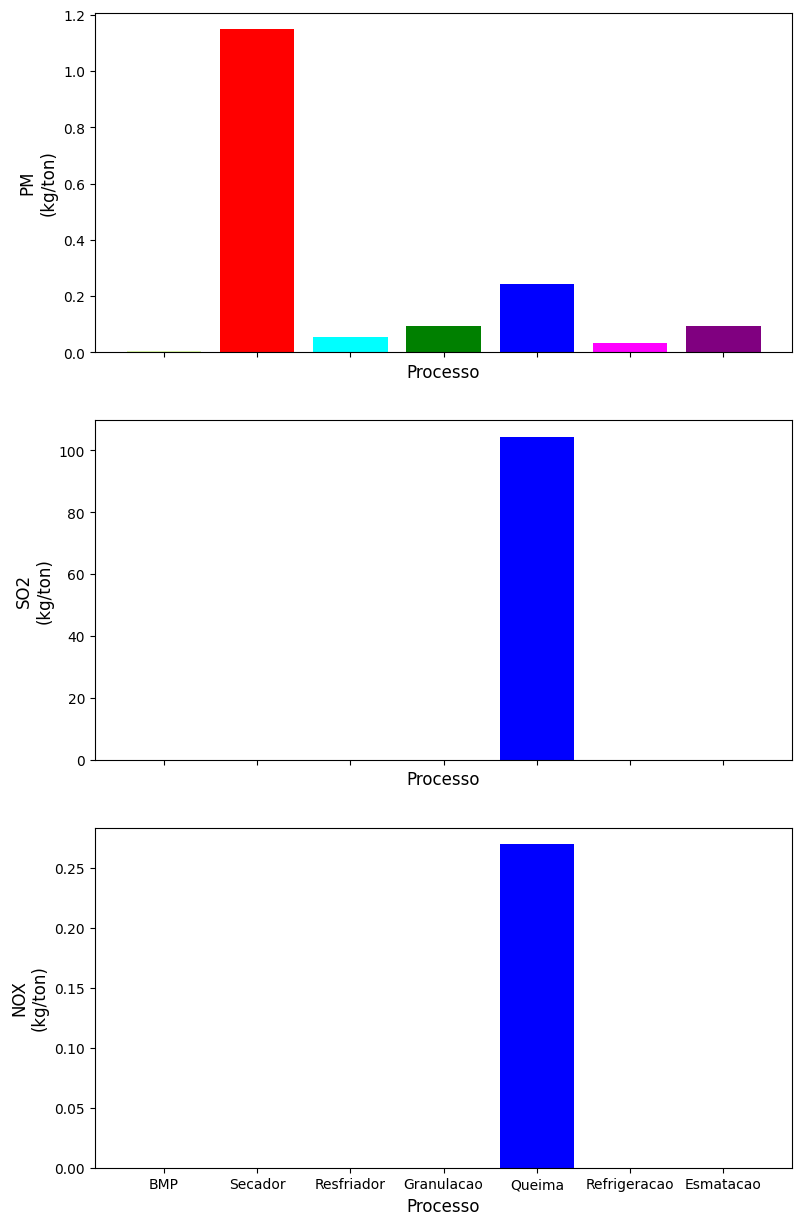

In [187]:
resultado_pm, resultado_so2, resultado_nox, df_resultado = verificacao_emissao(fe, df)

# Gráfico da sazonalidade durante o ano

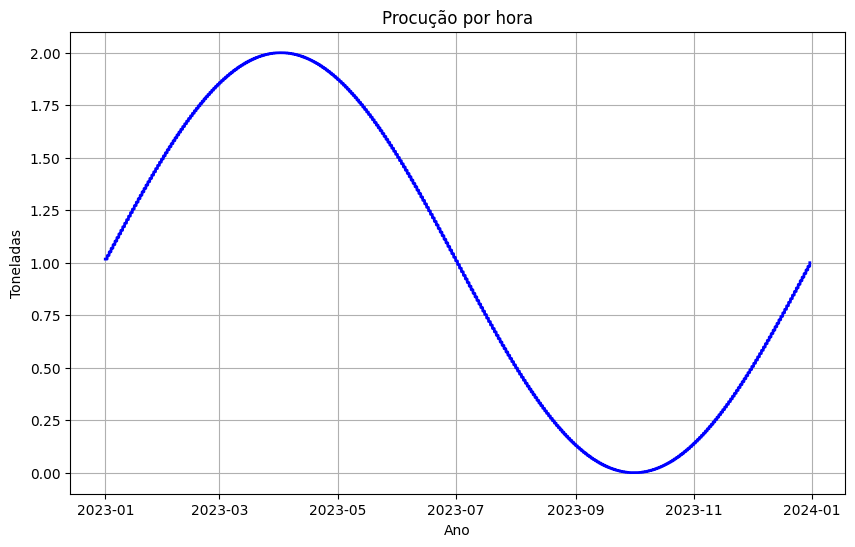

In [188]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['sazonalidade'], color='blue', linewidth=2)
plt.title('Procução por hora')
plt.xlabel('Ano')
plt.ylabel('Toneladas')
plt.grid(True)
plt.show()

# Gráfico da taxa de produção no ano, considerando a sazonalidade e o método monte carlo

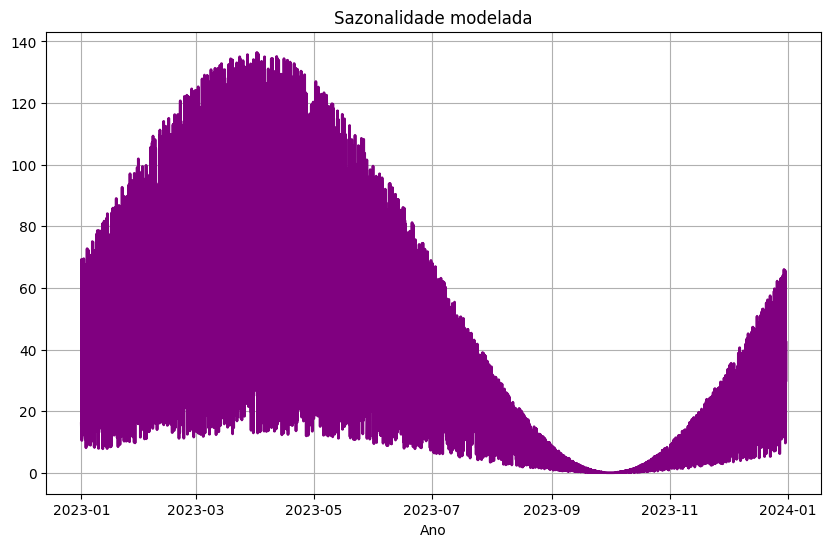

In [189]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['producao_diaria'], color='purple', linewidth=2)
plt.title('Sazonalidade modelada')
plt.xlabel('Ano')
plt.ylabel('')
plt.grid(True)
plt.show()

# Gráfico representando a emissão de PM durante o ano

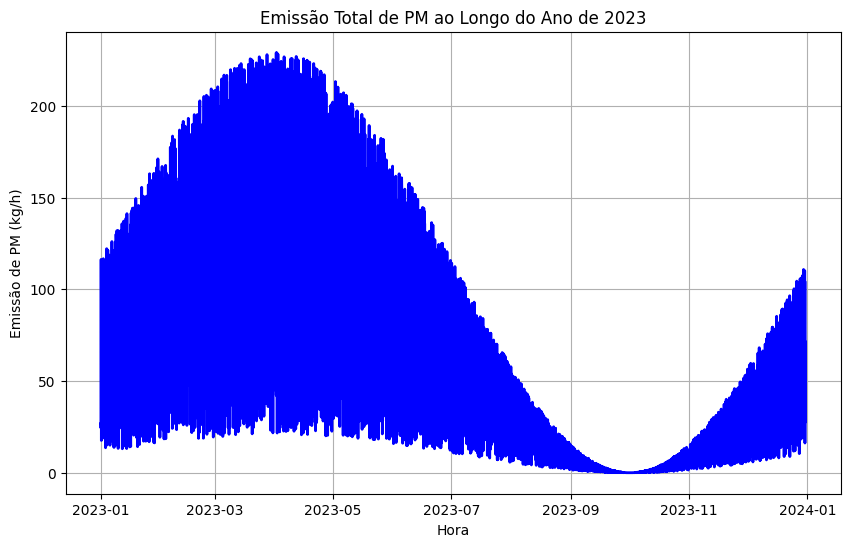

soma de toda as emissões de PM =  542780.0734676771
média das emissões de PM =  62.12430736725159
mínimo valor de emissoes PM =  0.0001263802706384652
máximo valor de emissoes PM =  228.98163174942067


In [190]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, resultado_pm, color='blue', linewidth=2)
plt.title('Emissão Total de PM ao Longo do Ano de 2023')
plt.xlabel('Hora')
plt.ylabel('Emissão de PM (kg/h)')
plt.grid(True)
plt.show()

soma_emissoes_pm = resultado_pm.sum()
media_emissoes_pm = np.mean(resultado_pm)
minimo_emissoes_pm = np.min(resultado_pm)
max_emissoes_pm = np.max(resultado_pm)

print('soma de toda as emissões de PM = ', soma_emissoes_pm)
print('média das emissões de PM = ', media_emissoes_pm)
print('mínimo valor de emissoes PM = ', minimo_emissoes_pm)
print('máximo valor de emissoes PM = ', max_emissoes_pm)



# Gráfico representando a emissão de SO2 durante o ano

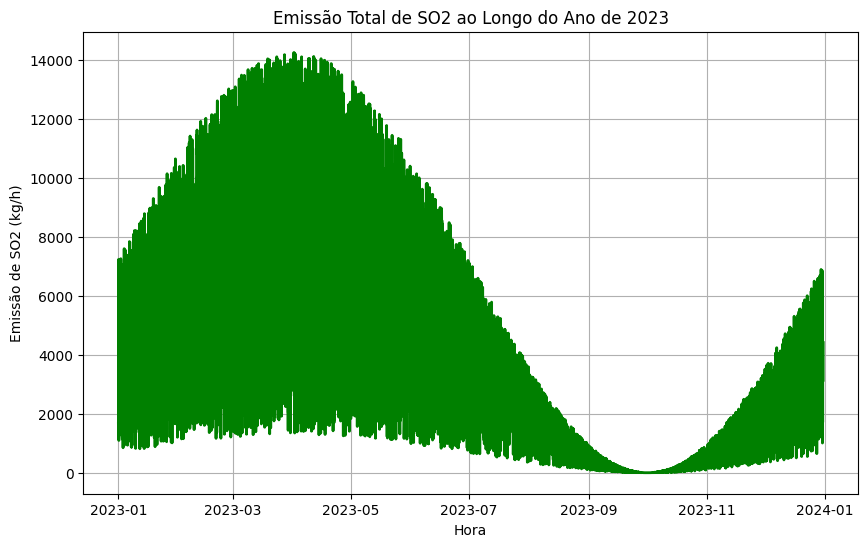

soma de toda as emissões de SO2 =  33772264.17229667
média das emissões de SO2 =  3865.4302589328913
mínimo valor de emissoes SO2 =  0.007863494064733322
máximo valor de emissoes SO2 =  14247.442999591822


In [191]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, resultado_so2, color='green', linewidth=2)
plt.title('Emissão Total de SO2 ao Longo do Ano de 2023')
plt.xlabel('Hora')
plt.ylabel('Emissão de SO2 (kg/h)')
plt.grid(True)
plt.show()

soma_emissoes_so2 = resultado_so2.sum()
media_emissoes_so2 = np.mean(resultado_so2)
minimo_emissoes_so2 = np.min(resultado_so2)
max_emissoes_so2 = np.max(resultado_so2)

print('soma de toda as emissões de SO2 = ', soma_emissoes_so2)
print('média das emissões de SO2 = ', media_emissoes_so2)
print('mínimo valor de emissoes SO2 = ', minimo_emissoes_so2)
print('máximo valor de emissoes SO2 = ', max_emissoes_so2)

# Gráfico representando as emissões de NOX durante o ano

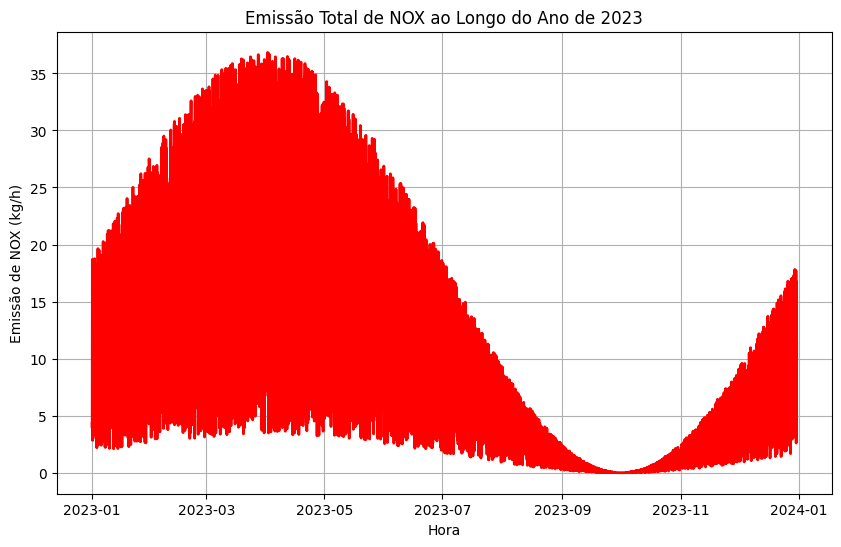

soma de toda as emissões de NOX =  87258.4815934938
média das emissões de NOX =  9.987236075711778
mínimo valor de emissoes NOX =  2.0317161698354036e-05
máximo valor de emissoes NOX =  36.81157521425638


In [192]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, resultado_nox, color='red', linewidth=2)
plt.title('Emissão Total de NOX ao Longo do Ano de 2023')
plt.xlabel('Hora')
plt.ylabel('Emissão de NOX (kg/h)')
plt.grid(True)
plt.show()

soma_emissoes_nox = resultado_nox.sum()
media_emissoes_nox = np.mean(resultado_nox)
minimo_emissoes_nox = np.min(resultado_nox)
max_emissoes_nox = np.max(resultado_nox)

print('soma de toda as emissões de NOX = ', soma_emissoes_nox)
print('média das emissões de NOX = ', media_emissoes_nox)
print('mínimo valor de emissoes NOX = ', minimo_emissoes_nox)
print('máximo valor de emissoes NOX = ', max_emissoes_nox)

# Gráfico demonstrando as emissões por processo

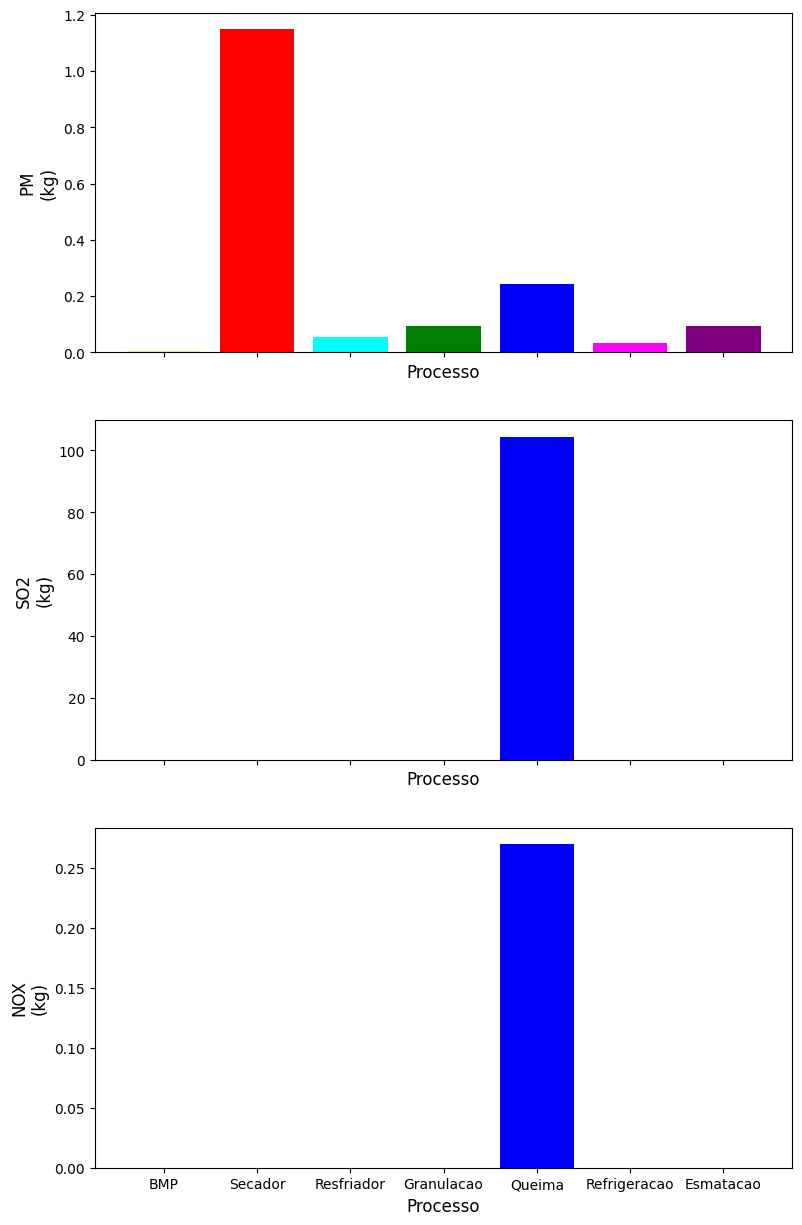

In [193]:
# Criar a figura e os eixos
fig, ax = plt.subplots(len(df_resultado.columns)-1, 1, sharex=True, figsize=(9, 15))

# Iterar sobre as colunas do DataFrame df_resultado
for ii in range(1, len(df_resultado.columns)):
    # Plotar as barras para cada coluna
    ax[ii-1].bar(fe['Source'], fe.iloc[:, ii], color=['#DAF7A6', 'red', 'cyan', 'green', 'blue', 'magenta', 'purple'])
    # Definir os rótulos dos eixos
    ax[ii-1].set_xlabel('Processo', fontsize=12)  # Definir o rótulo do eixo x
    ax[ii-1].set_ylabel(fe.columns[ii]+'\n(kg)', fontsize=12)  # Definir o rótulo do eixo y

# Exibir o gráficos
plt.show()